In [199]:
import numpy as np
import pandas as pd
from pgs_calculator import calculate_pgs
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [225]:
all_train_snp = pd.read_csv("./csv/all_train_snp_selected.csv")
validation_snp = pd.read_csv("./csv/validation_snp_selected.csv")

In [226]:
all_train_pgs = pd.read_csv("./pgs_results_calculated/all_train_pgs.csv")
validation_pgs = pd.read_csv("./pgs_results_calculated/validation_pgs.csv")

In [227]:
all_train_pca = np.loadtxt('./csv/all_train_pca_n.csv', delimiter=',')
validation_pca = np.loadtxt('./csv/validation_pca_n.csv', delimiter=',')

In [228]:
all_train_snp.shape, all_train_pgs.shape, all_train_pca.shape

((1120, 82), (1120, 76), (1120, 240))

In [229]:
X_pgs_train = all_train_pgs.drop(columns=["y", "FID", "IID"])
y_pgs_train = all_train_pgs["y"]
X_pgs_val = validation_pgs.drop(columns=["y", "FID", "IID"])
y_pgs_val = validation_pgs["y"]

means = X_pgs_train.mean()
X_pgs_train = X_pgs_train.fillna(means)
X_pgs_val = X_pgs_val.fillna(means)

selector = SelectKBest(f_classif, k=8)
X_pgs_train = selector.fit_transform(X_pgs_train, y_pgs_train)
X_pgs_val = selector.transform(X_pgs_val)

In [249]:
y_s_train = all_train_snp["target"]
y_s_val = validation_snp["target"]

means = all_train_snp.mean()
all_train_snp = all_train_snp.fillna(means)
validation_snp = validation_snp.fillna(means)

all_train_selected = np.concatenate([all_train_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), X_pgs_train], axis=1)
val_selected = np.concatenate([validation_snp.drop(columns=["Unnamed: 0", "target"]).to_numpy(), X_pgs_val], axis=1)

X_s_train = all_train_selected
X_s_val = val_selected

ss = StandardScaler()
X_s_train = ss.fit_transform(X_s_train)
X_s_val = ss.transform(X_s_val)

ROC-AUC на валидационных данных 8 PGS и все взятые сырые snp: 0.76


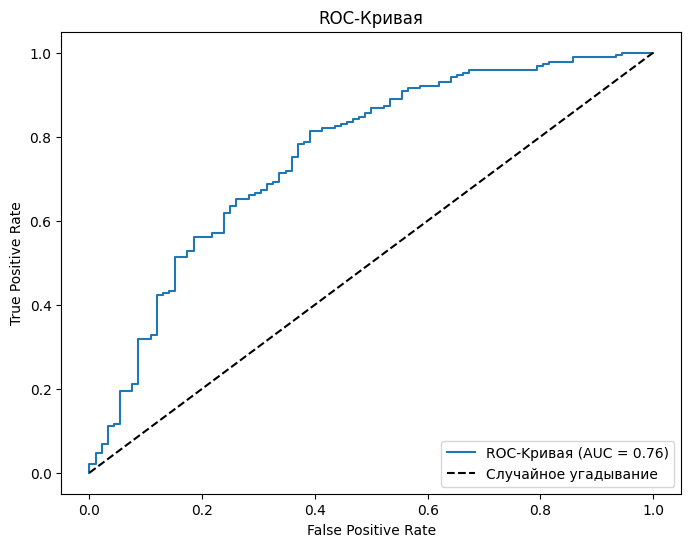

In [250]:
model = LogisticRegression()
model.fit(X_s_train, y_s_train)

y_val_pred_probs = model.predict_proba(X_s_val)[:, 1]

roc_auc = roc_auc_score(y_s_val, y_val_pred_probs)
print(f"ROC-AUC на валидационных данных 8 PGS и все взятые сырые snp: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_s_val - 1, y_val_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-Kривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Кривая')
plt.legend(loc='lower right')
plt.show()

In [251]:
X_snp_train = all_train_snp.drop(columns=["Unnamed: 0", "target"])
y_snp_train = all_train_snp["target"]
X_snp_val = validation_snp.drop(columns=["Unnamed: 0", "target"])
y_snp_val = validation_snp["target"]

means = X_snp_train.mean()
X_snp_train = X_snp_train.fillna(means)
X_snp_val = X_snp_val.fillna(means)

selector = SelectKBest(f_classif, k=40)
X_snp_train = selector.fit_transform(X_snp_train, y_snp_train)
X_snp_val = selector.transform(X_snp_val)

In [252]:
y_s_train = y_snp_train
y_s_val = y_snp_val

all_train_selected = np.concatenate([X_snp_train, X_pgs_train], axis=1)
val_selected = np.concatenate([X_snp_val, X_pgs_val], axis=1)

X_s_train = all_train_selected
X_s_val = val_selected

ss = StandardScaler()
X_s_train = ss.fit_transform(X_s_train)
X_s_val = ss.transform(X_s_val)

ROC-AUC на валидационных данных 8 PGS 40 SNP: 0.77


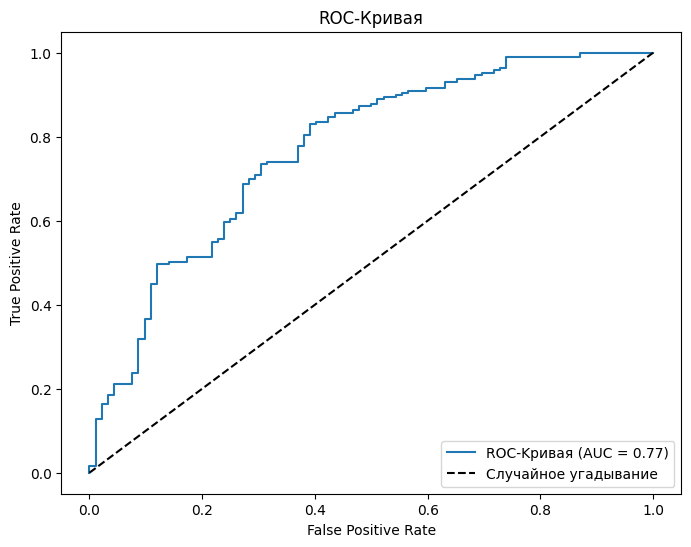

In [253]:
model = LogisticRegression()
model.fit(X_s_train, y_s_train)

y_val_pred_probs = model.predict_proba(X_s_val)[:, 1]

roc_auc = roc_auc_score(y_s_val, y_val_pred_probs)
print(f"ROC-AUC на валидационных данных 8 PGS 40 SNP: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_s_val - 1, y_val_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-Kривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Кривая')
plt.legend(loc='lower right')
plt.show()

In [284]:
from sklearn.ensemble import RandomForestClassifier

aucs = []
for i in range(1, 6):
    train_snp = pd.read_csv(f"./csv/train_{i}_snp_selected.csv")
    test_snp = pd.read_csv(f"./csv/test_{i}_snp_selected.csv")

    train_pgs = pd.read_csv(f"./pgs_results_calculated/train_{i}_pgs.csv")
    test_pgs = pd.read_csv(f"./pgs_results_calculated/test_{i}_pgs.csv")

    X_pgs_train = train_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_train = train_pgs["y"]
    X_pgs_test = test_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_test = test_pgs["y"]

    means = X_pgs_train.mean()
    X_pgs_train = X_pgs_train.fillna(means)
    X_pgs_test = X_pgs_test.fillna(means)

    selector = SelectKBest(f_classif, k=8)
    X_pgs_train = selector.fit_transform(X_pgs_train, y_pgs_train)
    X_pgs_test = selector.transform(X_pgs_test)

    X_snp_train = train_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_train = train_snp["target"]
    X_snp_test = test_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_test = test_snp["target"]

    means = X_snp_train.mean()
    X_snp_train = X_snp_train.fillna(means)
    X_snp_test = X_snp_test.fillna(means)

    y_s_train = y_snp_train
    y_s_test = y_snp_test

    train_selected = np.concatenate([X_snp_train, X_pgs_train], axis=1)
    test_selected = np.concatenate([X_snp_test, X_pgs_test], axis=1)


    X_s_train = train_selected
    X_s_test = test_selected

    ss = StandardScaler()
    X_s_train = ss.fit_transform(X_s_train)
    X_s_test = ss.transform(X_s_test)

    model = LogisticRegression()
    model.fit(X_s_train, y_s_train)

    y_test_pred_probs = model.predict_proba(X_s_test)[:, 1]

    roc_auc = roc_auc_score(y_s_test, y_test_pred_probs)
    aucs.append(roc_auc)
    print(f"ROC-AUC на валидационных данных, все 80 snp: {roc_auc:.2f}")
print(np.mean(aucs))

ROC-AUC на валидационных данных, все 80 snp: 0.71
ROC-AUC на валидационных данных, все 80 snp: 0.72
ROC-AUC на валидационных данных, все 80 snp: 0.73
ROC-AUC на валидационных данных, все 80 snp: 0.72
ROC-AUC на валидационных данных, все 80 snp: 0.75
0.7249871740604057


In [255]:
aucs = []
for i in range(1, 6):
    train_snp = pd.read_csv(f"./train_{i}_snp_selected.csv")
    test_snp = pd.read_csv(f"./test_{i}_snp_selected.csv")

    train_pgs = pd.read_csv(f"./pgs_results_calculated/train_{i}_pgs.csv")
    test_pgs = pd.read_csv(f"./pgs_results_calculated/test_{i}_pgs.csv")

    X_pgs_train = train_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_train = train_pgs["y"]
    X_pgs_test = test_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_test = test_pgs["y"]

    means = X_pgs_train.mean()
    X_pgs_train = X_pgs_train.fillna(means)
    X_pgs_test = X_pgs_test.fillna(means)

    selector = SelectKBest(f_classif, k=8)
    X_pgs_train = selector.fit_transform(X_pgs_train, y_pgs_train)
    X_pgs_test = selector.transform(X_pgs_test)

    X_snp_train = train_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_train = train_snp["target"]
    X_snp_test = test_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_test = test_snp["target"]

    means = X_snp_train.mean()
    X_snp_train = X_snp_train.fillna(means)
    X_snp_test = X_snp_test.fillna(means)

    selector = SelectKBest(f_classif, k=40)
    X_snp_train = selector.fit_transform(X_snp_train, y_snp_train)[:, :4]
    X_snp_test = selector.transform(X_snp_test)[:, :4]

    y_s_train = y_snp_train
    y_s_test = y_snp_test

    train_selected = np.concatenate([X_snp_train, X_pgs_train], axis=1)
    test_selected = np.concatenate([X_snp_test, X_pgs_test], axis=1)


    X_s_train = train_selected
    X_s_test = test_selected

    ss = StandardScaler()
    X_s_train = ss.fit_transform(X_s_train)
    X_s_test = ss.transform(X_s_test)

    model = LogisticRegression()
    model.fit(X_s_train, y_s_train)

    y_test_pred_probs = model.predict_proba(X_s_test)[:, 1]

    roc_auc = roc_auc_score(y_s_test, y_test_pred_probs)
    aucs.append(roc_auc)
    print(f"ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: {roc_auc:.2f}")
print(np.mean(aucs))

ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.75
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.75
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
0.757140650232012


0.7571 результат для 1 и 3 набора признаков на кроссвалидации

In [259]:
X_snp_train = all_train_snp.drop(columns=["Unnamed: 0", "target"])
y_snp_train = all_train_snp["target"]
X_snp_val = validation_snp.drop(columns=["Unnamed: 0", "target"])
y_snp_val = validation_snp["target"]

means = X_snp_train.mean()
X_snp_train = X_snp_train.fillna(means)
X_snp_val = X_snp_val.fillna(means)

selector = SelectKBest(f_classif, k=40)
X_snp_train = selector.fit_transform(X_snp_train, y_snp_train)
X_snp_val = selector.transform(X_snp_val)

In [262]:
y_s_train = y_snp_train
y_s_val = y_snp_val

all_train_selected = np.concatenate([X_snp_train, X_pgs_train, all_train_pca], axis=1)
val_selected = np.concatenate([X_snp_val, X_pgs_val, validation_pca], axis=1)

X_s_train = all_train_selected
X_s_val = val_selected

ss = StandardScaler()
X_s_train = ss.fit_transform(X_s_train)
X_s_val = ss.transform(X_s_val)

ROC-AUC на валидационных данных 8 PGS 40 SNP все PCA: 0.7647


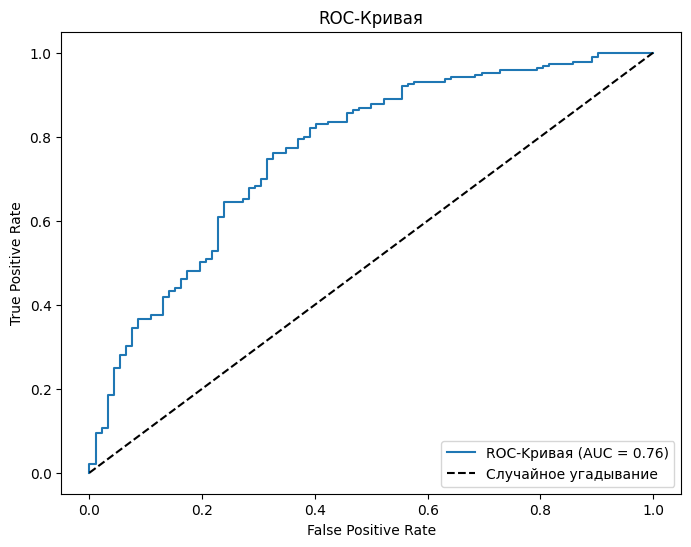

In [264]:
model = LogisticRegression()
model.fit(X_s_train, y_s_train)

y_val_pred_probs = model.predict_proba(X_s_val)[:, 1]

roc_auc = roc_auc_score(y_s_val, y_val_pred_probs)
print(f"ROC-AUC на валидационных данных 8 PGS 40 SNP все PCA: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_s_val - 1, y_val_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-Kривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Кривая')
plt.legend(loc='lower right')
plt.show()

In [280]:
selector = SelectKBest(f_classif, k=10)
X_all_train_pca = selector.fit_transform(all_train_pca, y_snp_train)
X_val_pca = selector.transform(validation_pca)

In [281]:
y_s_train = y_snp_train
y_s_val = y_snp_val

all_train_selected = np.concatenate([X_snp_train, X_pgs_train, X_all_train_pca], axis=1)
val_selected = np.concatenate([X_snp_val, X_pgs_val, X_val_pca], axis=1)

X_s_train = all_train_selected
X_s_val = val_selected

ss = StandardScaler()
X_s_train = ss.fit_transform(X_s_train)
X_s_val = ss.transform(X_s_val)

ROC-AUC на валидационных данных 8 PGS 40 SNP все PCA: 0.7704


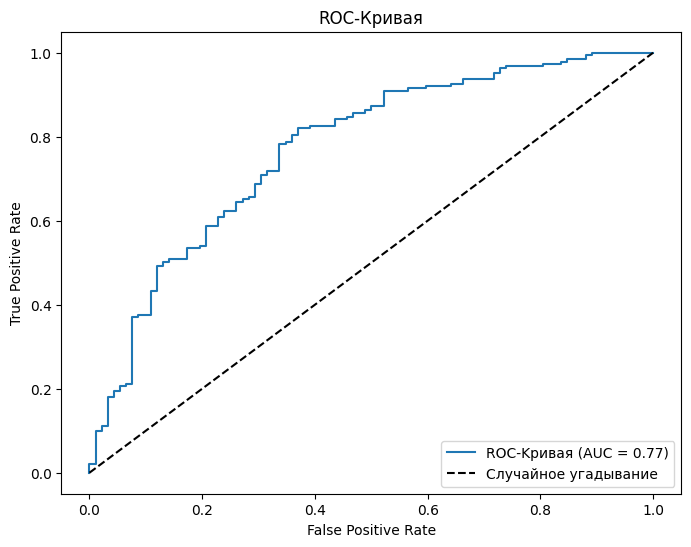

In [282]:
model = LogisticRegression()
model.fit(X_s_train, y_s_train)

y_val_pred_probs = model.predict_proba(X_s_val)[:, 1]

roc_auc = roc_auc_score(y_s_val, y_val_pred_probs)
print(f"ROC-AUC на валидационных данных 8 PGS 40 SNP все PCA: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_s_val - 1, y_val_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-Kривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Кривая')
plt.legend(loc='lower right')
plt.show()

In [286]:
aucs = []
for i in range(1, 6):
    train_snp = pd.read_csv(f"./csv/train_{i}_snp_selected.csv")
    test_snp = pd.read_csv(f"./csv/test_{i}_snp_selected.csv")

    train_pgs = pd.read_csv(f"./pgs_results_calculated/train_{i}_pgs.csv")
    test_pgs = pd.read_csv(f"./pgs_results_calculated/test_{i}_pgs.csv")

    train_pca = np.loadtxt(f'./csv/train_{i}_pca_n.csv', delimiter=',')
    test_pca = np.loadtxt(f'./csv/test_{i}_pca_n.csv', delimiter=',')

    X_pgs_train = train_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_train = train_pgs["y"]
    X_pgs_test = test_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_test = test_pgs["y"]

    means = X_pgs_train.mean()
    X_pgs_train = X_pgs_train.fillna(means)
    X_pgs_test = X_pgs_test.fillna(means)

    selector = SelectKBest(f_classif, k=8)
    X_pgs_train = selector.fit_transform(X_pgs_train, y_pgs_train)
    X_pgs_test = selector.transform(X_pgs_test)

    X_snp_train = train_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_train = train_snp["target"]
    X_snp_test = test_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_test = test_snp["target"]

    means = X_snp_train.mean()
    X_snp_train = X_snp_train.fillna(means)
    X_snp_test = X_snp_test.fillna(means)

    selector = SelectKBest(f_classif, k=40)
    X_snp_train = selector.fit_transform(X_snp_train, y_snp_train)[:, :4]
    X_snp_test = selector.transform(X_snp_test)[:, :4]

    y_s_train = y_snp_train
    y_s_test = y_snp_test

    train_selected = np.concatenate([X_snp_train, X_pgs_train, train_pca], axis=1)
    test_selected = np.concatenate([X_snp_test, X_pgs_test, test_pca], axis=1)


    X_s_train = train_selected
    X_s_test = test_selected

    ss = StandardScaler()
    X_s_train = ss.fit_transform(X_s_train)
    X_s_test = ss.transform(X_s_test)

    model = LogisticRegression()
    model.fit(X_s_train, y_s_train)

    y_test_pred_probs = model.predict_proba(X_s_test)[:, 1]

    roc_auc = roc_auc_score(y_s_test, y_test_pred_probs)
    aucs.append(roc_auc)
    print(f"ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: {roc_auc:.2f}")
print(np.mean(aucs))

ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.73
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.68
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.75
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.73
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.73
0.7249214623570368


In [287]:
aucs = []
for i in range(1, 6):
    train_snp = pd.read_csv(f"./csv/train_{i}_snp_selected.csv")
    test_snp = pd.read_csv(f"./csv/test_{i}_snp_selected.csv")

    train_pgs = pd.read_csv(f"./pgs_results_calculated/train_{i}_pgs.csv")
    test_pgs = pd.read_csv(f"./pgs_results_calculated/test_{i}_pgs.csv")

    train_pca = np.loadtxt(f'./csv/train_{i}_pca_n.csv', delimiter=',')
    test_pca = np.loadtxt(f'./csv/test_{i}_pca_n.csv', delimiter=',')

    selector = SelectKBest(f_classif, k=10)
    X_train_pca = selector.fit_transform(train_pca, y_snp_train)
    X_test_pca = selector.transform(test_pca)

    X_pgs_train = train_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_train = train_pgs["y"]
    X_pgs_test = test_pgs.drop(columns=["y", "FID", "IID"])
    y_pgs_test = test_pgs["y"]

    means = X_pgs_train.mean()
    X_pgs_train = X_pgs_train.fillna(means)
    X_pgs_test = X_pgs_test.fillna(means)

    selector = SelectKBest(f_classif, k=8)
    X_pgs_train = selector.fit_transform(X_pgs_train, y_pgs_train)
    X_pgs_test = selector.transform(X_pgs_test)

    X_snp_train = train_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_train = train_snp["target"]
    X_snp_test = test_snp.drop(columns=["Unnamed: 0", "target"])
    y_snp_test = test_snp["target"]

    means = X_snp_train.mean()
    X_snp_train = X_snp_train.fillna(means)
    X_snp_test = X_snp_test.fillna(means)

    selector = SelectKBest(f_classif, k=40)
    X_snp_train = selector.fit_transform(X_snp_train, y_snp_train)[:, :4]
    X_snp_test = selector.transform(X_snp_test)[:, :4]

    y_s_train = y_snp_train
    y_s_test = y_snp_test

    train_selected = np.concatenate([X_snp_train, X_pgs_train, X_train_pca], axis=1)
    test_selected = np.concatenate([X_snp_test, X_pgs_test, X_test_pca], axis=1)


    X_s_train = train_selected
    X_s_test = test_selected

    ss = StandardScaler()
    X_s_train = ss.fit_transform(X_s_train)
    X_s_test = ss.transform(X_s_test)

    model = LogisticRegression()
    model.fit(X_s_train, y_s_train)

    y_test_pred_probs = model.predict_proba(X_s_test)[:, 1]

    roc_auc = roc_auc_score(y_s_test, y_test_pred_probs)
    aucs.append(roc_auc)
    print(f"ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: {roc_auc:.2f}")
print(np.mean(aucs))

ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.75
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.75
ROC-AUC на валидационных данных, 8 PGS 40 отобранных SNP: 0.76
0.7550484814849828
